<img typeof="foaf:Image" src="indata/ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# Analysis of Protein Turnover in <i>T. brucei</i>

Michele Tinti

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee

In [1]:
import numpy as np
from lmfit import Model
import os
import pandas as pd
import numpy as np
from scipy import stats
from lmfit import Minimizer, Parameters, report_fit
from tqdm import tqdm_notebook as tqdm
#plotting
import matplotlib.pyplot as plt
import lmfit
from sklearn.metrics import mean_squared_error

## Analysis Start
This is the third analysis notebook for the protein turnover in T. brucei. In here we fit the BSF and PCF data.
### Setting up
<ul>
    <li>Download data files from
        <a href="https://uod.box.com/s/gdqrld2i3n1xun0kkot4mfq3bgg2w54b">here</a>
    </li>
    <li>in the same folder were this notebook sits create a new "indata" folder
    </li>
    <li>Move the data files to the "indata" folder
    </li>    
</ul> 

In [17]:
from lmfit import Minimizer, Parameters, report_fit
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
#liner decay
def lin_dec_model(x, params):
    slope, intercept =  params['slope'].value, params['intercept'].value
    return intercept + x * slope

#exponential decay
def exp_dec_model(x, params):
    A, tau, offset = params['A'].value, params['tau'].value,  params['offset'].value
    return A * np.exp( - x / tau ) + offset

#linear decay, resids is the quantity to minimize 
def lin2min(params, x, data, std):
    """minimize lin"""
    slope = params['slope']
    intercept = params['intercept']
    model = intercept + x * slope
    resids = model - data
    resids = resids  / std 
    return resids

#exponential decay, resids is the quantity to minimize 
def exp2min(params, x, data, std):
    """minimize exp decay"""
    A = params['A']
    tau = params['tau']
    offset = params['offset']
    model = A * np.exp( - x / tau ) + offset
    resids = model - data
    resids = resids / std 
    return resids

#function to assemble dataset for protein
def assemble_data(prot, df, x=[0, 0.25, 0.5, 1, 2, 4, 8, 20, 28], remove=[(6,1)]):
    temp=pd.DataFrame()
    step = len(x)
    temp['x']=x
    #print(df.loc[prot])
    temp['y1']=df.loc[prot][0:step].values
    #print([round(n,3) for n in list(temp['y1'].values)])
    temp['y2']=df.loc[prot][step:step*2].values
    #print([round(n,3) for n in list(temp['y2'].values)])
    temp['y3']=df.loc[prot][step*2:step*3].values
    #print([round(n,3) for n in list(temp['y3'].values)])
    #mean skipna defoult=True
    for r in remove:
        #print(r,r[0],r[1])
        temp.iloc[r[0],r[1]]=np.nan
    temp['y']=temp[['y1','y2','y3']].mean(axis=1)
    temp['std_0']=temp[['y1','y2','y3']].std(axis=1, ddof=0)
    temp['std_1']=temp[['y1','y2','y3']].std(axis=1, ddof=1)
    temp['std_2']=temp[['y1','y2','y3']].std(axis=1, ddof=2)
    return temp

#plot protein data and fit
def plot_prot(result, data, model):
    fig,ax=plt.subplots()
    ax.errorbar(data['x'], data['y'], data['std_0'], 
                marker='s', markersize='3', ls='none', label='data')
    x=np.arange(data['x'].min(), data['x'].max(), 0.01)
    y=[model(n,result) for n in x]
    
    ax.plot(x ,y, label='deg')
    
    y=[-model(n,result) for n in x]
    ax.plot(x ,y, label='syn')
    ax.set_ylim(0,1.1)
    plt.legend()
    #ax.set_ylim(0,1)
    plt.show()

    
    

#report all scoring functions for Regression metrics     
def score(y_true, y_pred):
    #Explained variance regression score function    
    evs = metrics.explained_variance_score(y_true, y_pred)
    #Mean absolute error regression loss
    mae = metrics.mean_absolute_error(y_true, y_pred)
    #Mean squared error regression loss
    #print ('y_true',y_true)
    #print('y_pred', y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    #Mean squared logarithmic error regression loss
    #try:
    temp = np.array(y_pred)
    temp[temp < 0] = 0
    msle = metrics.mean_squared_log_error(y_true, temp)
        
    rmse = np.sqrt(metrics.mean_squared_error(y_true, temp)) 
        
    #except:
        
        #msle = np.nan
        
        #rmse = np.nan
        
    #Median absolute error regression loss
    mdae = metrics.median_absolute_error(y_true, y_pred)
    #R^2 (coefficient of determination) regression score function.
    r2 = metrics.r2_score(y_true, y_pred)
    return {'evs':evs, 'mae':mae, 'mse':mse, 'msle':msle, 'rmse':rmse, 'mdae':mdae, 'r2':r2}

#compute half life for the model
def half_life(params):
    if 'tau' in params:
        hl = params['tau'].value/np.log(2)
    else:
        slope, intercept=params['slope'].value, params['intercept'].value
        half_x = intercept / 2.0
        hl =( half_x / slope )-( intercept / slope )
    return hl

#compute residual protein at specified time point
def residual_life(time_point, params):
    if 'tau' in params:
        hl = exp_dec_model(time_point, params)
    else:
        hl = lin_dec_model(time_point, params)
    return hl

In [18]:
#function to facilitate the fitting
def get_res(time_point, selection):
    temp_res={}
    params = Parameters()
    params.add('A', value=0.9, min=0)
    params.add('offset', value=0.2, min=0)
    params.add('tau', value=2, min=0)
    minner = Minimizer(exp2min, params, fcn_args=(selection['x'].values, 
                                                  selection['y'].values, 
                                                  selection['std_0'].values))
    result = minner.minimize()
    y_pred = [exp_dec_model(n, result.params) for n in selection['x']]
    result.ext_scores = score(selection['y'].values, y_pred)
    result.half_life = half_life(result.params)
    result.residual_life = residual_life(time_point, result.params)
    result.residual_hlife = residual_life(time_point/2, result.params)
    temp_res['exp']=result
    
    #plot_prot(result.params, selection, exp_dec_model)

    params = Parameters()
    params.add('slope',     value=-0.035, min=-np.inf, max=0)
    params.add('intercept', value=0.955, min=0)
    minner = Minimizer(lin2min, params, fcn_args=(selection['x'].values, 
                                                  selection['y'].values, 
                                                  selection['std_0'].values))

    result = minner.minimize()
    y_pred = [lin_dec_model(n, result.params) for n in selection['x']]
    #print(selection['y'].values)
    #print(selection['x'].values)
    #print(lin_dec_model(12, result.params))
    #print(y_pred)
    #plot_prot(result.params, selection, lin_dec_model)
    result.ext_scores = score(selection['y'].values, y_pred)

    result.half_life = half_life(result.params)
    
    temp_res['lin']=result
    return temp_res


In [19]:
bsf_df = pd.read_table(os.path.join('outdata','data_BSF.csv'),sep=',')
print (bsf_df.shape)
bsf_df.drop_duplicates(subset=['protein_id'],inplace=True)
print (bsf_df.shape)
bsf_df.set_index('protein_id', inplace=True)
bsf_df.head()

(6023, 22)
(6021, 22)


/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,0h_A,05h_A,1h_A,2h_A,4h_A,8h_A,12h_A,0h_B,05h_B,1h_B,...,4h_B,8h_B,12h_B,0h_C,05h_C,1h_C,2h_C,4h_C,8h_C,12h_C
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb04.24M18.150,NaN,0.798932,NaN,0.483426,0.420648,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.5.4450,NaN,0.921368,0.720377,0.830568,0.665113,0.429748,0.170499,NaN,0.922198,NaN,...,0.618335,0.369340,0.157660,NaN,NaN,NaN,0.734280,0.546403,0.311116,0.116054
Tb927.5.4460,0.963234,0.905850,0.884178,0.813065,0.644687,0.381774,0.243727,0.943307,0.933602,0.896085,...,0.630973,0.386476,0.227201,0.931520,0.924008,0.876607,0.795228,0.642655,0.395169,0.212608
Tb927.5.4470,NaN,0.826359,0.857143,0.796103,0.560330,0.401305,0.330977,NaN,0.872280,0.883049,...,0.611830,0.386643,0.252726,NaN,0.899392,0.843847,0.789909,0.583053,0.394115,0.287123
Tb927.5.4480,1.008286,0.995069,0.944232,0.888709,0.700682,0.446654,0.270179,1.024706,0.953290,0.962790,...,0.713562,0.433284,0.276344,0.989257,0.976796,0.951932,0.890329,0.721817,0.436291,0.268575


In [20]:
x= [0.0,  0.5,  1.0,  2.0,  4.0,  8.0,  12.0]
#bsf_df = pd.read_csv('data_BSF.csv', index_col=['protein_id'])
res_bsf = {}
time_point = 11.85
for prot in tqdm(bsf_df.index.values):
    #prot='Tb927.11.14610'
    #print(prot)
    data = assemble_data(prot, bsf_df, x=x, remove=[(6,1)])
    #print(data)
    selection=data[data.std_1.notna()]
    if selection.shape[0]>=4:
        temp_res = get_res(time_point, selection)
        temp_res['q']=1
        res_bsf[prot]=temp_res
    #break

In [21]:
22.27/2

11.135

In [22]:
print (len(res_bsf))

4391


In [23]:
pcf_df = pd.read_table(os.path.join('outdata','data_PCF.csv'),sep=',')
print (pcf_df.shape)
pcf_df.drop_duplicates(subset=['protein_id'],inplace=True)
print (pcf_df.shape)
pcf_df.set_index('protein_id', inplace=True)
pcf_df.head()

(5895, 28)
(5895, 28)


/Users/mtinti/miniconda3/envs/prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,0h_A,025h_A,0.5h_A,1h_A,2h_A,4h_A,8h_A,20h_A,28h_A,0h_B,...,28h_B,0h_C,025h_C,0.5h_C,1h_C,2h_C,4h_C,8h_C,20h_C,28h_C
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4450,NaN,NaN,NaN,NaN,NaN,0.806257,0.613254,0.363577,0.294020,NaN,...,0.258285,NaN,NaN,NaN,0.969097,0.932706,0.804186,0.651418,0.389308,0.282735
Tb927.5.4460,NaN,NaN,0.920623,NaN,0.927513,0.881835,0.767122,0.435937,0.331637,NaN,...,0.311502,0.938502,0.938015,NaN,0.972545,0.959288,0.841176,0.746439,0.442146,0.310078
Tb927.5.4470,NaN,NaN,NaN,NaN,0.850046,0.718234,0.526867,0.284066,0.145569,NaN,...,0.208142,NaN,NaN,0.757162,NaN,0.880486,0.739012,0.531159,NaN,0.291859
Tb927.5.4480,0.940893,0.907011,0.904121,0.939990,0.896921,0.807715,0.701846,0.426154,0.325024,0.939002,...,0.317768,0.938984,0.915895,0.906684,0.899439,0.854198,0.823202,0.675715,0.389552,0.304305
Tb927.5.4500,0.946735,0.931802,0.929127,0.917865,0.871949,0.771979,0.627461,0.360660,0.301985,0.946252,...,0.257409,0.946010,0.926772,0.927732,0.917921,0.886602,0.808561,0.615278,0.390830,0.285595


In [24]:
x= [0, 0.25, 0.5, 1, 2, 4, 8, 20, 28]
res_pcf = {}
time_point = 22.272
for prot in tqdm(pcf_df.index.values):
    #prot='Tb927.3.5790'
    #print(prot)
    data = assemble_data(prot, pcf_df, x=x)
    #print(data)
    selection = data[data.std_1.notna()]
    if selection.shape[0]>=4:
        #print('placeholder 1')
        temp_res = get_res(time_point, selection)
        temp_res['q']=1
        res_pcf[prot]=temp_res 

In [25]:
def unpack(res):
    frame = {}
    for prot in tqdm(res):
        temp = []
        temp.append(res[prot]['q'])
        temp.append(res[prot]['exp'].params['A'].value)
        temp.append(res[prot]['exp'].params['A'].stderr)
        temp.append(res[prot]['exp'].params['tau'].value)
        temp.append(res[prot]['exp'].params['tau'].stderr)
        temp.append(res[prot]['exp'].params['offset'].value)
        temp.append(res[prot]['exp'].params['offset'].stderr)
        temp.append(res[prot]['exp'].half_life)
        temp.append(res[prot]['exp'].chisqr)
        temp.append(res[prot]['exp'].redchi)
        temp.append(res[prot]['exp'].aic)
        temp.append(res[prot]['exp'].bic)
        temp.append(res[prot]['exp'].ext_scores['mse'])
        temp.append(res[prot]['exp'].ext_scores['mae'])
        temp.append(res[prot]['exp'].ext_scores['r2'])
        temp.append(res[prot]['exp'].ext_scores['rmse'])

        
        temp.append(res[prot]['lin'].params['slope'].value)
        temp.append(res[prot]['lin'].params['slope'].stderr)
        temp.append(res[prot]['lin'].params['intercept'].value)
        temp.append(res[prot]['lin'].params['intercept'].stderr)
        temp.append(res[prot]['lin'].half_life)
        
        temp.append(res[prot]['lin'].chisqr)
        temp.append(res[prot]['lin'].redchi)
        temp.append(res[prot]['lin'].aic)
        temp.append(res[prot]['lin'].bic)
        temp.append(res[prot]['lin'].ext_scores['mse'])
        temp.append(res[prot]['lin'].ext_scores['mae'])
        temp.append(res[prot]['lin'].ext_scores['r2'])
        temp.append(res[prot]['lin'].ext_scores['rmse'])
        frame[prot]=temp

    frame=pd.DataFrame.from_dict(frame,orient='index')
    frame.columns = ['quality',
                     'amplitude',
                     'amplitude_err',
                     'tau',
                     'tau_err',
                     'offset', 
                     'offset_err',
                     'exp_half_life',
                     
                     'exp_chisqr',
                     'exp_redchi',
                     
                     'exp_aic',
                     'exp_bic',
                     
                     'exp_mse',
                     'exp_mae',
                     'exp_r2',
                     'exp_rmse',
                     
                     'slope',
                     'slope_err',
                     'intercept',
                     'intercept_err',
                     'lin_half_life',
                     
                     'lin_chisqr',
                     'lin_redchi',
                     
                     'lin_aic',
                     'lin_bic',
                     
                     'lin_mse',
                     'lin_mae',
                     'lin_r2', 
                     'lin_rmse'
                    ]
    return frame

#get fit results, report if the linear fit is better than an exponential fit
table_bsf = unpack(res_bsf)
table_bsf['linear_is_better']=table_bsf['exp_aic']>table_bsf['lin_aic']
table_pcf = unpack(res_pcf)
table_pcf['linear_is_better']=table_pcf['exp_aic']>table_pcf['lin_aic']

In [26]:
print('bsf',table_bsf.quality.value_counts())
print('pcf',table_pcf.quality.value_counts())

bsf 1    4391
Name: quality, dtype: int64
pcf 1    3170
Name: quality, dtype: int64


In [27]:
table_bsf.index.names = ['protein_id']
table_pcf.index.names = ['protein_id']

In [28]:
table_bsf.to_csv(os.path.join('outdata','fit_BSF.csv'))
table_pcf.to_csv(os.path.join('outdata','fit_PCF.csv'))

## Visualization examples
### Static

      x        y1        y2        y3         y     std_0     std_1     std_2
0   0.0  0.910550       NaN       NaN  0.910550  0.000000       NaN       NaN
1   0.5  0.727374  0.679887  0.731600  0.712954  0.023445  0.028714  0.040608
2   1.0  0.462837  0.483740  0.504744  0.483774  0.017108  0.020953  0.029632
3   2.0  0.288585  0.292126  0.310421  0.297044  0.009569  0.011719  0.016574
4   4.0  0.122837  0.136824  0.143650  0.134437  0.008663  0.010610  0.015004
5   8.0  0.075680       NaN       NaN  0.075680  0.000000       NaN       NaN
6  12.0       NaN  0.106399  0.032437  0.069418  0.036981  0.052299       NaN


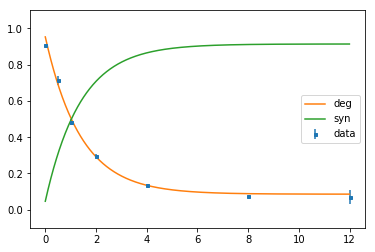

Parameters([('A',
             <Parameter 'A', value=0.8678680940011037 +/- 0.0525, bounds=[0:inf]>),
            ('offset',
             <Parameter 'offset', value=0.08560283538357782 +/- 0.0219, bounds=[0:inf]>),
            ('tau',
             <Parameter 'tau', value=1.3910188238901933 +/- 0.165, bounds=[0:inf]>)])

In [30]:
#plot protein data and fit
def plot_prot(result, data, model):
    fig,ax=plt.subplots()
    ax.errorbar(data['x'], data['y'], data['std_0'], 
                marker='s', markersize='3', ls='none', label='data')
    x=np.arange(data['x'].min(), data['x'].max(), 0.01)
    y=[model(n,result) for n in x]
    #print(y)
    ax.plot(x ,y, label='deg')
    
    y=[1-model(n,result) for n in x]
    ax.plot(x ,y, label='syn')
    
    ax.set_ylim(-0.1,1.1)
    plt.legend()
    #ax.set_ylim(0,1)
    plt.show()
prot = 'Tb927.10.7710'
x= [0.0,  0.5,  1.0,  2.0,  4.0,  8.0,  12.0]
selection=assemble_data(prot, bsf_df, x=x)
print(selection)
plot_prot(res_bsf[prot]['exp'].params, selection, exp_dec_model)
res_bsf[prot]['exp'].params

In [31]:
def new_half_life(params, dt):
    new_tau = 1/ (1/params['tau'].value)-(np.log(2)/dt)
    new_half_life=-new_tau*np.log( (params['A'].value-params['offset'].value)/ (params['A'].value*2) )
    return new_tau, new_half_life

def turnover(params):
    return params['tau'].value * (np.log(params['A'].value) - np.log(0.5-params['offset'].value))

In [33]:
a = res_bsf[prot]['exp'].params['A'].value
b = res_bsf[prot]['exp'].params['offset'].value
tau = res_bsf[prot]['exp'].params['tau'].value
print (a,b,tau)

0.8678680940011037 0.08560283538357782 1.3910188238901933


### Dynamic

In [34]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row
output_notebook()

Loading BokehJS ...

In [35]:
table_bsf.sort_values(['exp_mse']).tail()

,quality,amplitude,amplitude_err,tau,tau_err,offset,offset_err,exp_half_life,exp_chisqr,exp_redchi,...,lin_half_life,lin_chisqr,lin_redchi,lin_aic,lin_bic,lin_mse,lin_mae,lin_r2,lin_rmse,linear_is_better
protein_id,,,,,,,,,,,,,,,,,,,,,
Tb927.11.5530,1,1.428528e-10,0.059604,0.093473,9.144039e+07,6.678655e-02,0.465724,0.134853,297.943023,297.943023,...,8.435816e+06,297.943038,148.971519,21.242432,20.015021,0.073703,0.161050,-0.439206,0.271483,True
Tb927.5.3850,1,9.101166e-01,28.769904,17.634795,7.252382e+02,2.762659e-08,2.943304,25.441631,97.604176,48.802088,...,1.087937e+01,97.209488,32.403163,18.837152,18.056028,0.091303,0.200550,-0.743214,0.302163,True
Tb927.9.13540,1,2.430734e-01,339.531574,202.563556,2.925622e+05,2.295357e-07,86.953699,292.237438,534.618231,178.206077,...,9.136475e+01,534.244286,133.561071,30.934562,30.518081,0.113217,0.262692,-0.814705,0.336477,True
Tb927.10.7670,1,1.413548e+00,0.424529,1.997914,7.462082e-01,3.108981e-01,0.080915,2.882381,259.599119,86.533040,...,6.034992e+00,1084.628169,271.157042,35.183398,34.766917,0.010438,0.094401,0.831049,0.102167,False
Tb927.10.13610,1,1.006812e+00,0.436145,8.467888,1.247198e+01,1.045148e-08,0.611952,12.216580,238.251371,59.562843,...,7.986227e+00,170.402053,34.080411,26.345754,26.237574,0.122618,0.213846,-0.535971,0.350169,True


In [36]:
prot = 'Tb927.6.1460'
fx = np.arange(0, 12, 0.1)
params = res_bsf[prot]['exp'].params


#exponential decay
def dec_model(x, A, tau, offset):
    return A * np.exp( - x / tau ) + offset


fy=[dec_model(n, params['A'].value,
                  params['tau'].value,
                  params['offset'].value) for n in fx]


y=bsf_df.loc[prot][0:21]
x=[0, 0.5, 1, 2, 4, 8, 12]*3
def update(A= params['A'].value, 
           tau=params['tau'].value, 
           offset=params['offset'].value):
    r.data_source.data['y'] = [dec_model(n, A, tau, offset) for n in fx]
    push_notebook()

p = figure(title="prot",
           plot_height=300,
           plot_width=400, 
           y_range=(-0.05,1.05),
            x_range=(-0.5,12.5))
r = p.line(fx, fy, color="red", line_width=2)
r2 = p.scatter(x, y, color="#2222aa")

interact(update, 
         A=(0,1, 0.01), 
         tau=(0.01,50, 0.01), 
         offset=(0, 1, 0.01),
        )

show(p, notebook_handle=True)

interactive(children=(FloatSlider(value=0.9252755335404863, description='A', max=1.0, step=0.01), FloatSlider(…